In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
from glob import glob
from pprint import pprint
from itertools import combinations
from math import ceil

In [2]:
southeast_asia_frequencies = pd.read_csv('../../data/frequencies/regions/stiffness2/dengue_all_frequencies.j', index_col=0)
south_america_frequencies = pd.read_csv('../../data/frequencies/regions/seAsia_compare_params/)

frequencies.drop([g for g in frequencies.columns.values if 'SYLVATIC' in g], inplace=True, axis=1)
genotypes = frequencies.columns.tolist()
genotype_combinations = sorted([ sorted(g) for g in combinations(genotypes, 2) ])

In [3]:
# Bin seasons by the midpoint of each year (consistent with data collection @ Nicaraguan cohort study)
seasons = [(t+0.5, t+1.5) for t in range(1980, 2015)]

# Bin each pivot from augur (row in frequencies data) by which season it falls into. Average frequencies by season.
def bin_seasons(df, seasons=seasons):
    def find_season(date, seasons=seasons):
        season = np.nan
        for (start,end) in seasons:
            if date >= start and date < end:
                season = (start,end)
                break
        return season
    df['season'] = [find_season(date, seasons) for date in df.index.values]
    df.dropna(how='any', inplace=True)
    df = df.groupby('season').agg('mean')
    return df

frequencies = bin_seasons(frequencies, seasons)

print frequencies.head()

                   DENV1_I  DENV1_II  DENV1_IV   DENV1_V  DENV2_AMERICAN  \
season                                                                     
(1980.5, 1981.5)  0.284100  0.008200  0.055075  0.119200             0.0   
(1981.5, 1982.5)  0.274700  0.006475  0.053275  0.053850             0.0   
(1982.5, 1983.5)  0.193125  0.004625  0.037450  0.021775             0.0   
(1983.5, 1984.5)  0.131375  0.003800  0.025475  0.009950             0.0   
(1984.5, 1985.5)  0.128425  0.004700  0.024875  0.006150             0.0   

                  DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_ASIANII  \
season                                                               
(1980.5, 1981.5)             0.143500      0.130900         0.0001   
(1981.5, 1982.5)             0.149325      0.136200         0.0001   
(1982.5, 1983.5)             0.211800      0.193175         0.0001   
(1983.5, 1984.5)             0.241800      0.220500         0.0001   
(1984.5, 1985.5)             0.217700      0.19

In [4]:
def find_replicates(g1, g2, df):
    ''' Find all seasons that g1 and g2 both circulated at >= 5% frequency '''
    try:
        g1_seasons = df[df[g1] >= 0.05]['season'].tolist()
        g2_seasons = df[df[g2] >= 0.05]['season'].tolist()
        cocirculating_seasons = set(g1_seasons).intersection(set(g2_seasons))
        return sorted(list(cocirculating_seasons))
    except KeyError:
        print 'Oops, one or both of these genotypes was not in the dataframe.'
        print g1, g2
        print df.columns.values
        return []

def proportion_g1(g1, g2, df):
    g1_plus_g2 = df[g1]+df[g2]
    p = df[g1]/g1_plus_g2
#     p.dropna(inplace=True)
#     p = parse_seasons(p)
    return p

def have_cocirculated((g1, g2), df, min_freq = 0.05):
    g1_present = df.loc[df[g1] >= min_freq]
    cocirculating = g1_present.loc[g1_present[g2] >= min_freq]
    return len(cocirculating) > 0

In [7]:
cocirculating_genotype_combinations = [(g1,g2) for (g1,g2) in genotype_combinations 
                                       if have_cocirculated((g1,g2), frequencies, min_freq=0.1)]

genotype_comparisons = {(g1,g2): proportion_g1(g1, g2, frequencies) for (g1,g2) in cocirculating_genotype_combinations}

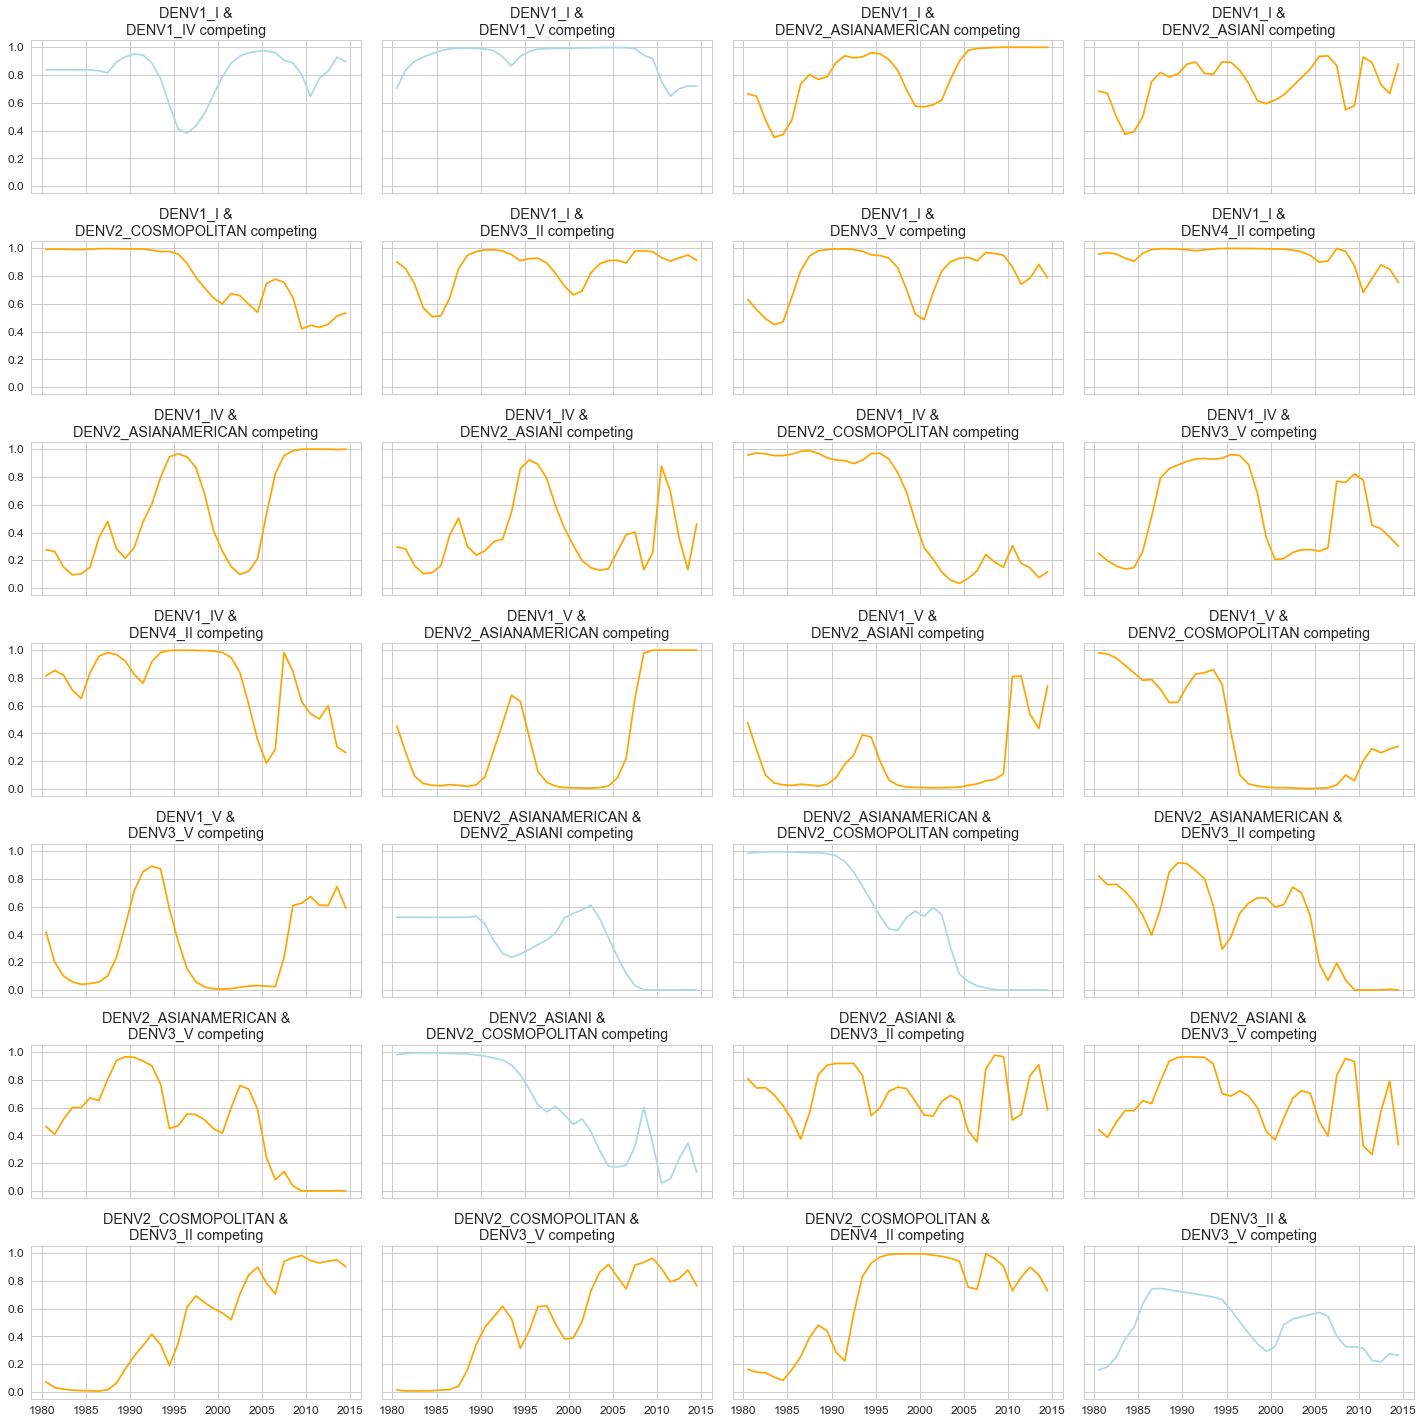

In [19]:
ncols = 4
nrows = int(ceil(len(genotype_comparisons)/ncols))

sns.set(style='whitegrid', font_scale=1.2)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(20,20), sharey=True, sharex=True)

for (g1,g2), ax in zip(cocirculating_genotype_combinations, axes.flatten()):
    p_g1 = genotype_comparisons[(g1,g2)]
    c = 'lightblue' if g1[4] == g2[4] else 'orange'

    ax.plot([s[0] for s in p_g1.index.tolist()], p_g1.values.tolist(), c=c)
    ax.set_title('%s &\n%s competing'%(g1,g2))
    plt.tight_layout()
    
# plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')
plt.show()

In [ ]:


fit = np.linregress(xvals, yvals)
{'titer_dist': xvals, 'cocirc_length': yvals, 'rvalue': fit.rvalue, 'slope': fit.slope}


In [10]:
def compare_seasons(((g1,g2), p_g1), window_size=3):
    season_p_g1_outcomes = []
    for s0 in p_g1.index.values[:-window_size]:
        s1 = (s0[0]+window_size, s0[1]+window_size)
        season_p_g1_outcomes.append((p_g1[s0], p_g1[s1]))
    return season_p_g1_outcomes
        

three_year_cocirculation_outcomes = { g : compare_seasons((g, p)) for g,p in genotype_comparisons.items() }

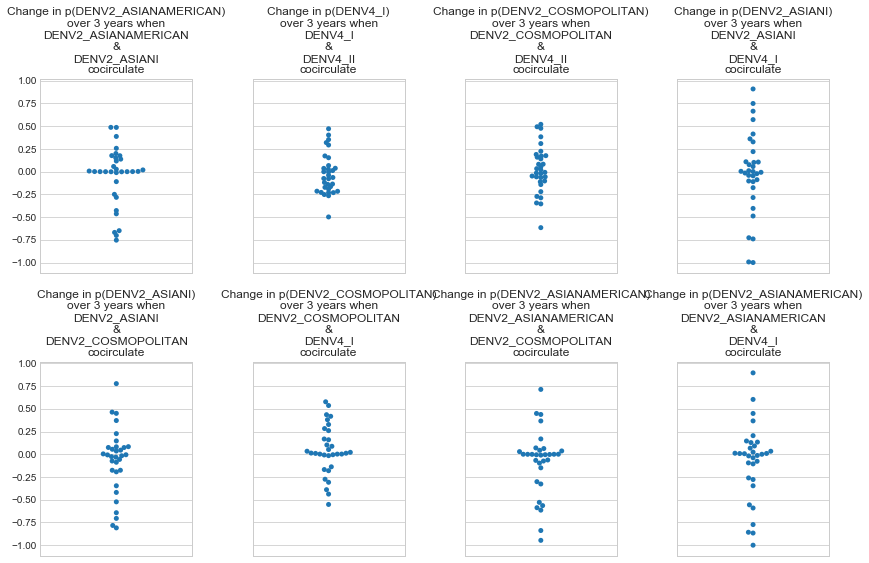

In [79]:
ncols = 4
nrows = int(ceil(len(genotype_comparisons)/ncols))

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(12,8), sharey=True, sharex=True)

for (g1,g2), ax in zip(genotype_comparisons.keys(), axes.flatten()):
    outcomes = three_year_cocirculation_outcomes[(g1,g2)]
    sns.swarmplot([t[1] - t[0] for t in  outcomes], ax=ax, orient="v")
    ax.set_title("Change in p(%s)\nover 3 years when\n%s\n&\n%s\ncocirculate"%(g1, g1, g2))
    plt.tight_layout()